In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import einops
from src.layers.flow import get_mask, MaskedLinear

In [ ]:
x = torch.randn(32,10,2)
x_hat = torch.randn(32,10,2)

mse_loss = torch.nn.functional.mse_loss(x_hat, x) * 10 * 2
sum_loss = torch.nn.functional.mse_loss(x_hat, x, reduction='sum') / 32
print(mse_loss)
print(sum_loss)

In [ ]:
x.sum()/32

In [ ]:
x.sum(dim=tuple(range(1, x.ndim))).mean()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
res = np.load('/home/user/data2/ICML_rebuttal/savings/uncond/etth2_24_S/KoVAEorig/cond_None_dtm_True_syn.npy')
# res = np.load('/home/user/data/ICML_rebuttal/savings/uncond/etth2_24_S/KoVAE_orig/cond_None_dtm_True_syn.npy')
start = np.random.randint(0, len(res))
_ = plt.plot(res[start, :, :].squeeze().T)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/home/user/workspaces/THU-timeseries/ETT-small/ETTh2.csv', index_col=0)
# df.values.shape
start = np.random.randint(0, len(df)-24)
_ = plt.plot(df.values[start:start+24, :])

In [ ]:
from abc import ABC, abstractmethod
from typing import List, Optional, Literal
from lightning import LightningModule
import torch
from torch.nn import functional as F

def _condition_shape_check(n_sample, condition, cond_type):
    assert n_sample >=1
    if cond_type is None:
    
        if condition.shape[0] == 1:
            condition = condition.repeat(
                n_sample, *[1 for _ in range(len(condition.shape) - 1)]
            )
        elif condition.shape[0] == n_sample:
            pass
        else:
            raise ValueError(
                "The batch size of the given condition should be the same as n_sample or just 1."
            )
 
    return condition


class BaseModel(ABC, LightningModule):
    """Base class for generative models in PyTorch Lightning"""
    ALLOW_CONDITION = ...
    
    def __init__(self, seq_len, seq_dim, condition, lr, **kwargs):
        super().__init__()
        if condition not in self.ALLOW_CONDITION:
            raise ValueError(f"Condition '{condition}' not allowed. Choose from {self.ALLOW_CONDITION}")
    
    @torch.no_grad()  # wrap with torch.no_grad()
    def sample(self, n_sample: int = 1, condition=None, **kwargs):
        """Generate samples from the generative model"""
        condition = _condition_shape_check(n_sample, condition, self.condition)
        self.eval()
        return self._sample_impl(n_sample, condition, **kwargs)

    @abstractmethod
    def _sample_impl(self, n_sample: int = 1, condition=None, **kwargs) -> torch.Tensor:
        """Actual implementation of the sampling process"""


class MyModel(BaseModel):
    """AAAAAAA

    Args:
        BaseModel (_type_): _description_

    Returns:
        _type_: _description_
    """
    ALLOW_CONDITION = [None, 'predict']
    def __init__(self, seq_len, seq_dim, condition, lr, **kwargs):
        """aaaaaaa

        Args:
            seq_len (_type_): _description_
            seq_dim (_type_): _description_
            condition (_type_): _description_
            lr (_type_): _description_
        """
        super().__init__(seq_len, seq_dim, condition, lr, **kwargs)
    
    def _sample_impl(self, n_sample = 1, condition=None, **kwargs):
        return super()._sample_impl(n_sample, condition, **kwargs)

MyModel
model = MyModel(24, 1, 'impute', 0.001)

In [ ]:
import torch

total_seq_len = 64
num_samples = 200
t = torch.linspace(0, 4 * torch.pi, total_seq_len).float()
curves = []
labels = []
for _ in range(num_samples):
    a = torch.rand(1).item() * 0.5  # Initial radius
    b = torch.rand(1).item() * 0.2  # Growth rate

    direction = torch.randint(0, 2, (1,)).item()  # 0=clockwise, 1=ccw

    r = a + b * t
    if direction == 0:
        x = r * torch.cos(t)
        y = r * torch.sin(t)
    else:
        x = -r * torch.cos(t)
        y = r * torch.sin(t)

    x += torch.randn_like(x) * 0.01
    y += torch.randn_like(y) * 0.01

    curve = torch.stack([x, y], dim=1)
    curves.append(curve)
    labels.append(direction)
data, class_cond = torch.stack(curves), torch.tensor(labels).unsqueeze(-1)
print(data.shape, class_cond.shape)

class_cond[1,...,...]

tensor([[[ True, False],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[False,  True],
         [ True,  True],
         [ True, False],
         ...,
         [False,  True],
         [ True, False],
         [ True, False]],

        [[ True,  True],
         [ True, False],
         [ True,  True],
         ...,
         [ True, False],
         [ True,  True],
         [ True,  True]],

        ...,

        [[ True, False],
         [ True, False],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[False,  True],
         [False,  True],
         [ True, False],
         ...,
         [ True,  True],
         [ True,  True],
         [ True,  True]],

        [[False,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [ True, 

/tmp/ipykernel_1277282/1918018879.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/home/user/workspaces/GenTS/data/2DSpiral/data_tsl64.pt')
/tmp/ipyke

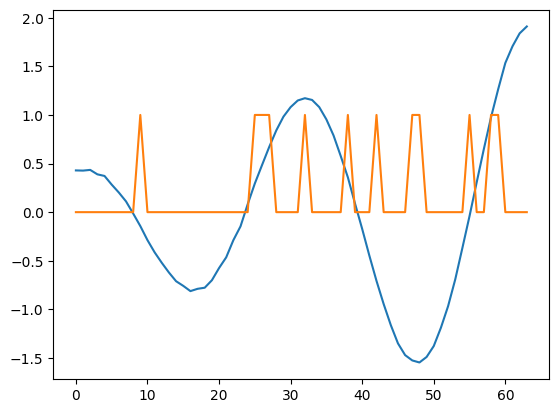

In [4]:
import torch
import matplotlib.pyplot as plt

data = torch.load('/home/user/workspaces/GenTS/data/2DSpiral/data_tsl64.pt')
cond = torch.load('/home/user/workspaces/GenTS/data/2DSpiral/impute_cond_tsl64.pt')
print(~cond)
plt.plot(data[0,:,0])
plt.plot(cond[0,:,0])